This is the cumulative result of using a pretrained version of EfficientNet B0 with the PyTorch Feature Attribution Tutorial: https://captum.ai/tutorials/CIFAR_TorchVision_Interpret

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


In [ ]:
# Number of classes in the dataset
num_classes = 10

# Batch size for training (change depending on how much memory you have)
# https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/
# 128 seems to be a common choice
batch_size = 128

# Number of epochs to train for
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    # save the weights in statedict
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # 
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
# set to True so we only tune the classifier 
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
# initialize our model
model_ft = models.efficientnet_b0(pretrained=True)
set_parameter_requires_grad(model_ft, feature_extracting=True) # don't update gradients for the other layers
num_ftrs = model_ft.classifier[1].in_features # should be 1280
model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes) # numclasses defined earlier

# input size for efficientnet_b0 is 224 according to: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
input_size = 224

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [ ]:
model_ft.classifier[1]

Linear(in_features=1280, out_features=10, bias=True)

In [ ]:
## From PyTorch site, may not be most optimal for our dataset
data_transforms =  transforms.Compose([
        transforms.RandomResizedCrop(input_size), # Need to keep the gradient 
        transforms.RandomHorizontalFlip(), # remove flip 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # should be 0.5 across the board
    ])

## CORRECTED data transforms

img_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.ToTensor()   
])

print("Initializing Datasets and Dataloaders...")

# Create training, validation, and testing datasets
train = datasets.CIFAR10(root="CIFAR-10-test", train=True, transform=img_transform, download=True)
train, validation = random_split(train, [40000, 10000], generator=torch.Generator().manual_seed(42))
#print("Size of Training Set: {0}".format(len(train)))
#print("Size of Validation Set: {0}".format(len(validation)))
test = datasets.CIFAR10(root="CIFAR-10-test", train=False, transform=img_transform)
#print("Size of Test Set: {0}".format(len(test)))

image_datasets = {'train':train, 'validation':validation, 'test':test}

# Create training, validation, and testing dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'validation', 'test']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR-10-test/cifar-10-python.tar.gz to CIFAR-10-test


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

# Observe that all parameters are being optimized
import torch.optim as optim
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, 
                             optimizer_ft, num_epochs=num_epochs)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.9958 Acc: 0.3718
validation Loss: 1.6998 Acc: 0.5356

Epoch 1/9
----------
train Loss: 1.6162 Acc: 0.5152
validation Loss: 1.4621 Acc: 0.5659

Epoch 2/9
----------
train Loss: 1.4673 Acc: 0.5396
validation Loss: 1.3479 Acc: 0.5802

Epoch 3/9
----------
train Loss: 1.3892 Acc: 0.5523
validation Loss: 1.2976 Acc: 0.5824

Epoch 4/9
----------
train Loss: 1.3383 Acc: 0.5606
validation Loss: 1.2411 Acc: 0.5912

Epoch 5/9
----------
train Loss: 1.3012 Acc: 0.5694
validation Loss: 1.2218 Acc: 0.5922

Epoch 6/9
----------
train Loss: 1.2865 Acc: 0.5724
validation Loss: 1.1993 Acc: 0.6007

Epoch 7/9
----------
train Loss: 1.2713 Acc: 0.5712
validation Loss: 1.1719 Acc: 0.6048

Epoch 8/9
----------
train Loss: 1.2548 Acc: 0.5766
validation Loss: 1.1597 Acc: 0.6090

Epoch 9/9
----------
train Loss: 1.2324 Acc: 0.5820
validation Loss: 1.1606 Acc: 0.6085

Training complete in 29m 60s
Best val Acc: 0.000000


In [ ]:
# save the model to drive (for future usage)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!ls drive/MyDrive
torch.save(model_ft, 'efficientnet_b0_weights.pth')

In [ ]:
# install captum
!pip install captum

     |████████████████████████████████| 1.4 MB 4.7 MB/s 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


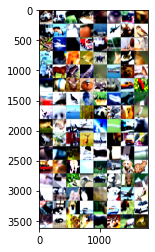

GroundTruth:    car truck  deer  frog
Predicted:    dog   car plane   cat


In [ ]:
# taken from CIFAR Captum tutorial, slightly adapted for current setup

# be careful with CPU vs GPU 
# https://stackoverflow.com/questions/53900910/typeerror-can-t-convert-cuda-tensor-to-numpy-use-tensor-cpu-to-copy-the-tens
# https://stackoverflow.com/questions/59013109/runtimeerror-input-type-torch-floattensor-and-weight-type-torch-cuda-floatte

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img, transpose = True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(dataloaders_dict["test"])
images, labels = dataiter.next()
images, labels = images.cuda(), labels.cuda()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


outputs = model_ft(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
ind = 3

input = images[ind].unsqueeze(0)
input.requires_grad = True

In [ ]:
model_ft.eval()

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [ ]:
from captum.attr import IntegratedGradients
def attribute_image_features(algorithm, input, **kwargs):
    model_ft.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions

ig = IntegratedGradients(model_ft)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.0025], device='cuda:0', dtype=torch.float64)


In [ ]:
original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


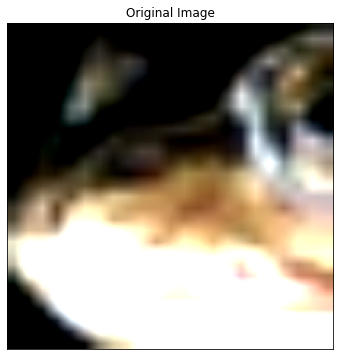

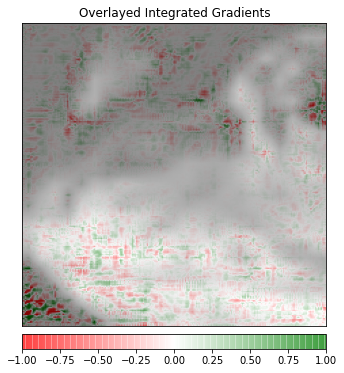

In [ ]:
from captum.attr import visualization as viz

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")
_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

In [ ]:
attr_ig

array([[[-6.56012128e-04, -2.13157607e-04, -2.53310225e-05],
        [-5.00487573e-04,  2.50009815e-04,  1.05986080e-04],
        [-3.58431794e-05,  9.15239951e-04,  4.40538351e-04],
        ...,
        [ 1.22382325e-04, -6.03105953e-04, -1.77894317e-04],
        [-2.28161789e-04, -7.33206440e-04, -4.12105268e-04],
        [-4.58361324e-04, -1.31932331e-03, -4.11677656e-04]],

       [[-5.05738248e-04, -7.91267925e-05, -9.53333789e-05],
        [ 1.48109005e-05,  1.03303597e-03,  4.37151176e-04],
        [ 1.45448548e-04,  1.14174401e-03,  6.01463995e-04],
        ...,
        [ 3.69274306e-04, -2.42852106e-04, -1.78671082e-04],
        [ 1.45418681e-04, -4.33516369e-05, -1.35136706e-04],
        [-4.73366571e-04, -1.24041143e-03, -4.67514112e-04]],

       [[-4.52324591e-04, -6.91637292e-04, -4.04689478e-04],
        [-4.27715880e-05,  2.33921782e-04,  1.21453305e-04],
        [-3.94355665e-04,  1.04666908e-04,  2.64244867e-04],
        ...,
        [ 1.68768714e-04, -1.90627558e-04,

In [ ]:
# larger dataset
ig = IntegratedGradients(model_ft)
# input should be some set of tensors
input = torch.randn(2, 3, 32, 32, requires_grad=True)
# attribution will give another tensor with all the proper values
attribution = ig.attribute(input, target=3)